#Mfundo Monchwe
#201726904
#AML Assignment 3



K-Means vs Gaussian Mixture Models
written by Eva Patel, Dharmender Singh Kushwaha

The increasing heterogeneity of cloud workloads such as big data, IoT, and business analytics need characterisation in order to build an effective capacity strategy and sustain cloud service providers' competitiveness.  Although K-means is a simple and quick clustering approach, it may not fully represent the heterogeneity inherent in Cloud workloads.
Gaussian Mixture Models are capable of detecting complicated patterns and grouping them into cohesive, homogenous components that are near representations of genuine patterns within the data set.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn import datasets
from sklearn.model_selection import train_test_split
import theano as T
import pandas as pd
import seaborn as sns
import arviz as az


A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

The GaussianMixture object implements the expectation-maximization (EM) algorithm for fitting mixture-of-Gaussian models. It can also draw confidence ellipsoids for multivariate models, and compute the Bayesian Information Criterion to assess the number of clusters in the data. A GaussianMixture.fit method is provided that learns a Gaussian Mixture Model from train data. Given test data, it can assign to each sample the Gaussian it mostly probably belong to using the GaussianMixture.predict method.

Pros
* it is the fastest algrorithm for learning mixture models

Cons
* When one has insufficiently many points per mixture, estimating the covariance matrices becomes difficult, and the algorithm is known to diverge and find solutions with infinite likelihood unless one regularizes the covariances artificially.



In [ ]:
boston_data = datasets.load_boston()
df_x = pd.DataFrame(data= boston_data.data, columns= boston_data.feature_names)
df_y = pd.DataFrame(data= boston_data.target)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state =111)

In [ ]:
boston_data

{'DESCR': ".. _boston_dataset:\n\nBoston house prices dataset\n---------------------------\n\n**Data Set Characteristics:**  \n\n    :Number of Instances: 506 \n\n    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.\n\n    :Attribute Information (in order):\n        - CRIM     per capita crime rate by town\n        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.\n        - INDUS    proportion of non-retail business acres per town\n        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)\n        - NOX      nitric oxides concentration (parts per 10 million)\n        - RM       average number of rooms per dwelling\n        - AGE      proportion of owner-occupied units built prior to 1940\n        - DIS      weighted distances to five Boston employment centres\n        - RAD      index of accessibility to radial highways\n        - TAX      full-value property-tax rate p

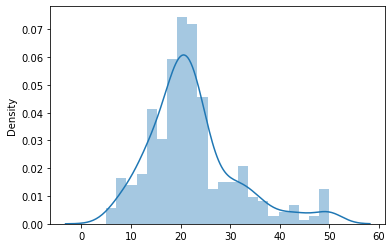

In [ ]:
sns.distplot(y_train)

In [ ]:
x_train = x_train.iloc[:,0:13]

In [ ]:
x_tr = T.shared(np.array(x_train))
y_tr = T.shared(np.array(y_train))

Here we describe variational inference algorithms on Dirichlet process mixture. The Dirichlet process is a prior probability distribution on clusterings with an infinite, unbounded, number of partitions. Variational techniques let us incorporate this prior structure on Gaussian mixture models at almost no penalty in inference time, comparing with a finite Gaussian mixture model.

In [ ]:
with pm.Model() as Model:
  #Priors
  theta = pm.Normal('Intercept', mu = 0, sigma=10, shape = (1))
  W = pm.Normal('weights', mu = 0, sigma=10, shape = (13,1))
  sigma = pm.HalfCauchy('sigma', 50)
  # Computing mean
  mu = pm.Deterministic('mu', theta + T.tensor.dot(x_tr, W))
  #Likelihood
  y_obs = pm.Normal('y_obs', mu = mu, sigma = sigma, observed = y_tr)
  trace = pm.sample(2000, tune = 1000, init ='advi')

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 40200
Interrupted at 40,199 [20%]: Average Loss = 2,874.4
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, weights, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 64 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4a9009910>,
      dtype=object)

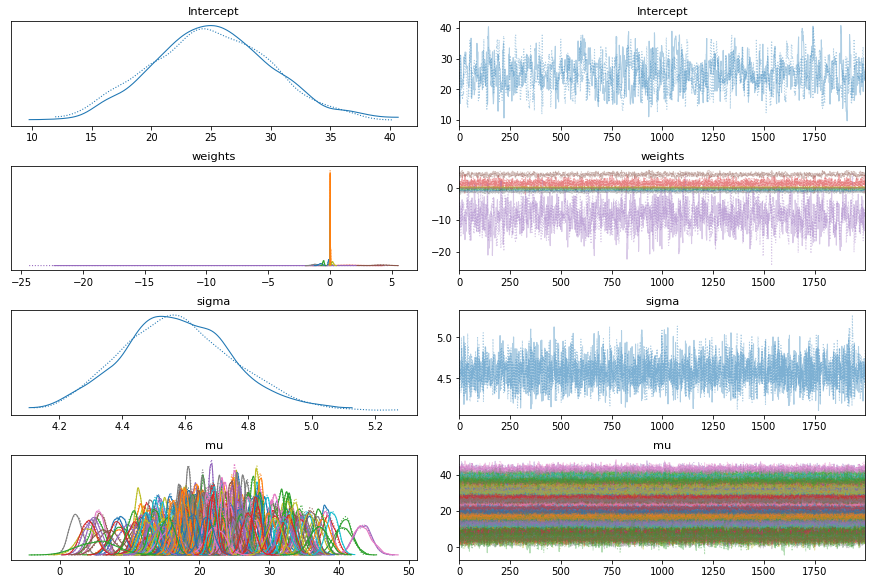

In [ ]:
az.plot_trace(trace)

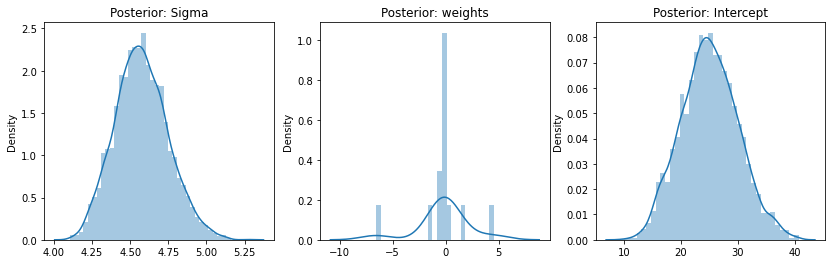

In [ ]:
_,axi = plt.subplots(1,3, figsize=(14,4))
sns.distplot(trace['sigma'], ax=axi[0]).set_title('Posterior: Sigma')
sns.distplot(trace['weights'][0], ax=axi[1]).set_title('Posterior: weights')
sns.distplot(trace['Intercept'], ax=axi[2]).set_title('Posterior: Intercept')
plt.show()

according to the article reviewed we discover that k-means has some weaknesses and we can try to improve the cluster model

for instance, suppose we have simple blobs of data, k-means algorithm can quickly label those clusters in a way it is closely matches

In [ ]:
from sklearn.datasets.samples_generator import make_blobs
x, y_true = make_blobs(n_samples = 400, centers = 4, cluster_std =0.65, random_state=0)
x = x[:, ::-1] #flip axes]

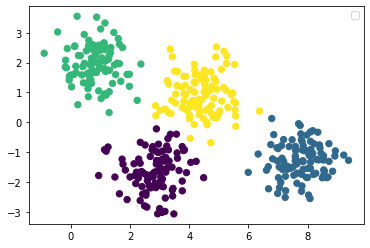

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(x).predict(x)
plt.legend('K Means Labels')
plt.scatter(x[:,0], x[:,1], c=labels, s=40, cmap = 'viridis')
plt.show()

given above data, there appears to very slight overlap between the two middle clusters, such that we might have complete confidence in the cluster assignment points between them. Unfortunately, the k-means model has no intrinsic measure of proability or uncertainty of cluster assignments.

one way out about the k-means model is that place a circle at the center of each cluster, with a radius defined by the most distant point in the cluster.


we can try to visualize this cluster  model with the followinh function

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, x, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(x)

    ax= ax or plt.gca()
    ax.axis('equal')
    ax.scatter(x[:,0], x[:,1], c =labels, s=40, cmap='viridis', zorder=2)

    centers = kmeans.cluster_centers_
    radii = [cdist(x[labels==i], [center]).max()
            for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
      ax.add_patch(plt.Circle(c,r, fc='#CCC', lw=3, alpha=0.5,zorder=1))


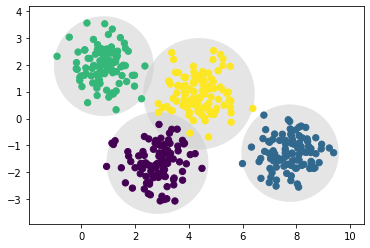

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans,x)

obervation for k-means is that these models cluster models must circular.

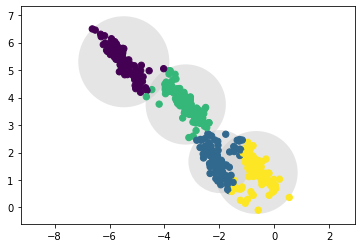

In [ ]:
rng = np.random.RandomState(13)
X_stred = np.dot(x, rng.randn(2,2))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stred)

we observe that these transformarions clusters are non-circular and these circular clusters are of poor fit. this result in mixing of cluster assignments where resulting circles overlap.



Although you could measure uncertainty in cluster assignment by comparing the distances of each point to all clusters centers, rather than focusing on just the closest.

there are two disadvantages of k-means
* it lacks flexibility in cluster shape
*lacks probabilistic cluster assignment

Gaussian mixture models
GMM attempts to find a mixture of multi-dimensional gaussian probability dists that best model any input dataset.
gmm can be used to find clusters in th same manner as k-means:

In [ ]:
!pip install GMM

     |████████████████████████████████| 92kB 10.5MB/s 
  Created wheel for GMM: filename=GMM-0.3.3-cp37-none-any.whl size=10952 sha256=038bed7c459313f1a4e7d4b1c290e376adcdab69b9527dcfc4ff1a892526ca10
  Stored in directory: /root/.cache/pip/wheels/a1/c1/d4/7931a8f0e684c97cde85165009e96d1abed97c175fbcf10fec
Successfully built GMM


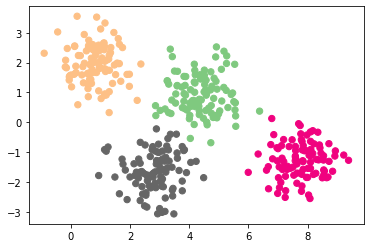

In [ ]:
from sklearn.mixture import GaussianMixture
gmm =GaussianMixture(n_components =4, random_state=0).fit(x)
labels = gmm.predict(x)
plt.scatter(x[:,0], x[:,1], c=labels, s =40, cmap='Accent_r')

GMM contains a probabilistic model under  the hood, its possible to find probabilistic cluster assignments. using predict_proba method, we return a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster

In [ ]:
probs = gmm.predict_proba(x)
print(probs[:5].round(3))

[[0.    0.082 0.    0.918]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


we can visualize this uncertainty by making the size of each point proportional to the certainty of its prediction

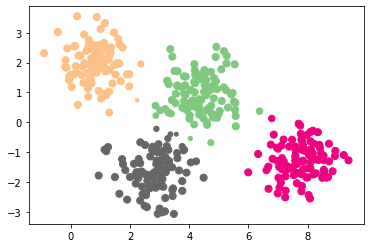

In [ ]:
size = 50* probs.max(1)**2
plt.scatter(x[:,0], x[:,1], c= labels,  cmap= 'Accent_r', s =size)

the result of this, each cluster is associated not with hard-edged sphere, but with smooth g model.

for k -means EM approach, this algorithm sometimes miss the globally optimal solution

gmm is very similar to k-means;
it uses expectation-maximation approach which qualitatively does the following:

* select initial guess for location and shape
* repeat until converged:
  * E-step: for every point, find weightd, encoding the probability of membeship in each cluster
  * M-step: for every cluster, update its location, normalization, and shape based on all data points, making use of the weights

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(x).predict(x)
    if label:
        ax.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(x[:, 0], x[:, 1], s=40, zorder=2)
    ax.axis('equal')
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


In [ ]:
gmm = gmm(n_components=4, random_state=43)
plot_gmm(gmm, x)

TypeError: ignored

AttributeError: ignored

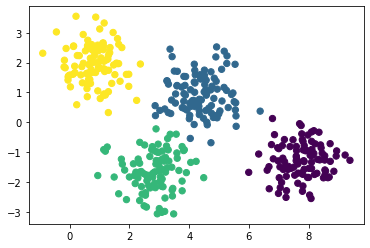

In [ ]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stred)

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

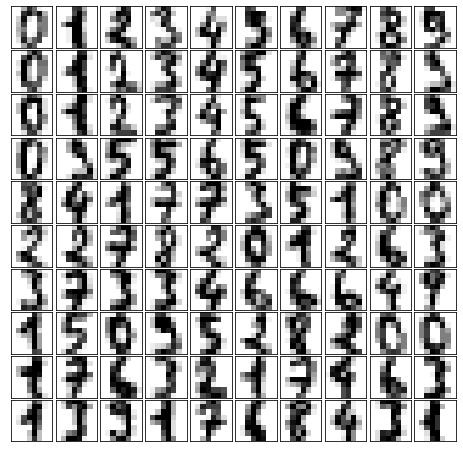

In [ ]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

In [ ]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

NameError: ignored